Loading Women's Data...

--- Final Results (No Decimals) ---
                   Any Method  Modern Method  Traditional Method
Rwamagana                  60             57                   3
Nyagatare                  71             65                   7
Gatsibo                    65             63                   2
Kayonza                    64             61                   2
Kirehe                     73             68                   5
Ngoma                      71             61                  10
Bugesera                   59             54                   5
East Province              66             62                   5
Rwanda (National)          64             58                   6
✅ Analysis Complete. JSON: eastern_contraception_married_final.json, Chart: Contraception_Married_Grouped.png


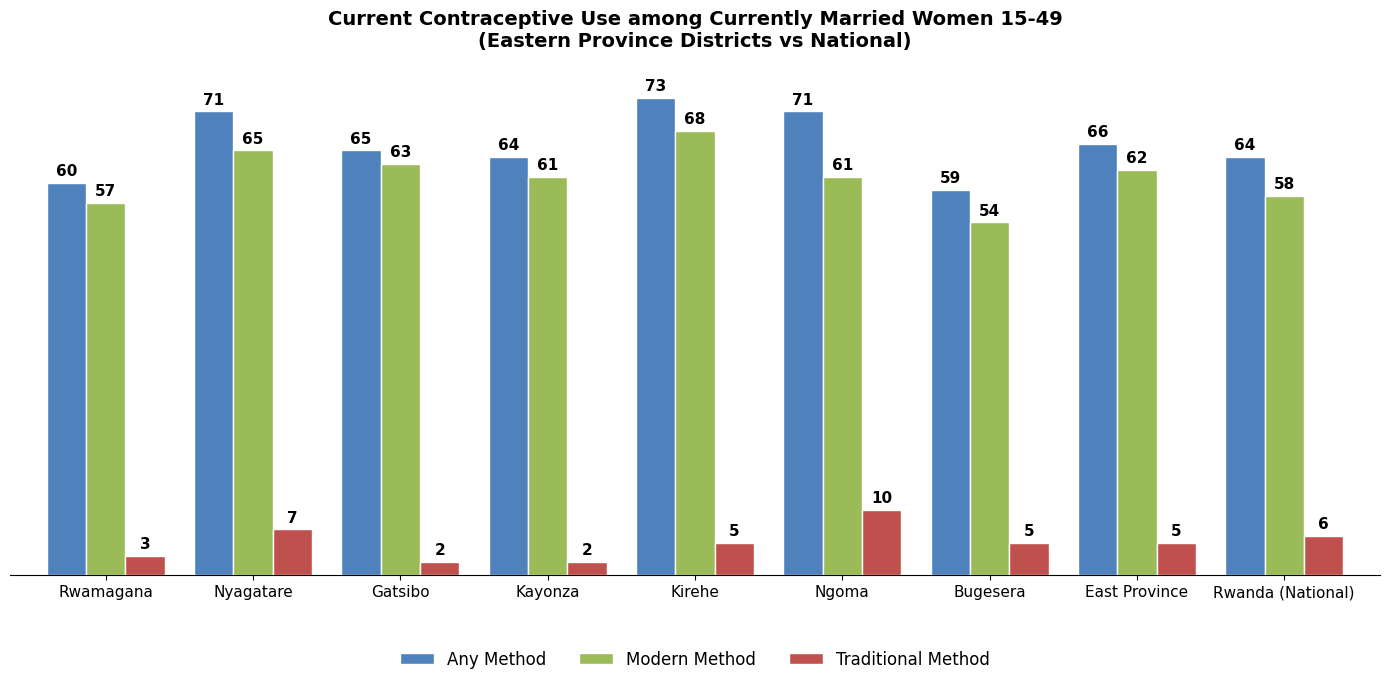

In [1]:
#!/usr/bin/env python3
# dhs_contraception_married_final.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math

# ------------------------------------------------------------------
# 1. SETTINGS
# ------------------------------------------------------------------
DATA_DIR = "data"
FILE_PATH = os.path.join(DATA_DIR, "RWIR81FL.DTA")

# Eastern Province Districts
DIST_MAP = {
    51: 'Rwamagana', 52: 'Nyagatare', 53: 'Gatsibo',
    54: 'Kayonza', 55: 'Kirehe', 56: 'Ngoma', 57: 'Bugesera'
}

# Colors for the three indicators
COLORS = ["#4F81BD", "#9BBB59", "#C0504D"] # Any (Blue), Modern (Green), Traditional (Red)

# ------------------------------------------------------------------
# 2. CALCULATION HELPERS (ROUNDING LOGIC)
# ------------------------------------------------------------------
def standard_round(n):
    """
    Rounds 0.5 and up to the next integer.
    Rounds below 0.5 to the lower integer.
    """
    return int(math.floor(n + 0.55))

def get_contraception_stats(df):
    """Calculates weighted percentages as clean integers."""
    if df.empty or df['w'].sum() == 0:
        return pd.Series({"Any Method": 0, "Modern Method": 0, "Traditional Method": 0})
    
    # Calculate weighted averages (floats)
    any_float = np.average(df['v313'] > 0, weights=df['w']) * 100
    modern_float = np.average(df['v313'] == 3, weights=df['w']) * 100
    trad_float = np.average((df['v313'] == 1) | (df['v313'] == 2), weights=df['w']) * 100
    
    # Apply standard rounding to remove decimals
    return pd.Series({
        "Any Method": standard_round(any_float),
        "Modern Method": standard_round(modern_float),
        "Traditional Method": standard_round(trad_float)
    })

# ------------------------------------------------------------------
# 3. ANALYSIS PIPELINE
# ------------------------------------------------------------------
if __name__ == "__main__":
    if not os.path.exists(FILE_PATH):
        print(f"❌ Error: {FILE_PATH} not found."); exit()

    print("Loading Women's Data...")
    df = pd.read_stata(FILE_PATH, convert_categoricals=False)
    df.columns = df.columns.str.lower()

    # --- FILTERS ---
    # 1. Currently Married (v502 == 1)
    # 2. Age 15-49 (v012)
    df = df[(df['v502'] == 1) & (df['v012'] >= 15) & (df['v012'] <= 49)].copy()
    
    # 3. Weights & Numeric conversion for Indicator (v313)
    df['w'] = pd.to_numeric(df['v005']) / 1000000.0
    df['v313'] = pd.to_numeric(df['v313'], errors='coerce').fillna(0)

    # --- AGGREGATION ---
    results = {}
    dist_col = 'sdistrict' if 'sdistrict' in df.columns else 'sdstr'
    
    # A. Districts (Eastern Province = Region 5)
    df_east = df[df['v024'] == 5].copy()
    for d_code, d_name in DIST_MAP.items():
        subset = df_east[df_east[dist_col] == d_code]
        results[d_name] = get_contraception_stats(subset)

    # B. Province Total
    results["East Province"] = get_contraception_stats(df_east)

    # C. National Total
    results["Rwanda (National)"] = get_contraception_stats(df)

    # Final DataFrame
    final_df = pd.DataFrame(results).T
    print("\n--- Final Results (No Decimals) ---")
    print(final_df)

    # --- JSON OUTPUT ---
    json_name = "eastern_contraception_married_final.json"
    with open(json_name, "w") as f:
        # Convert to native python ints for JSON compatibility
        json.dump(final_df.to_dict(orient='index'), f, indent=4)

    # --- PLOTTING ---
    ax = final_df.plot(kind="bar", figsize=(14, 7), color=COLORS, width=0.8, edgecolor="white")

    plt.title("Current Contraceptive Use among Currently Married Women 15-49\n(Eastern Province Districts vs National)", 
              fontsize=14, fontweight="bold", pad=20)
    
    plt.xticks(rotation=0, fontsize=11)
    plt.xlabel("")
    plt.grid(axis="y", ls="--", alpha=0.3)
    
    # Visual cleanup
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: 
        ax.spines[s].set_visible(False)
    
    plt.legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=3, fontsize=12)

    # Add numeric labels (integer format %d)
    for c in ax.containers:
        ax.bar_label(c, fmt='%d', padding=3, fontsize=11, fontweight="bold")

    plt.tight_layout()
    plt.savefig("Contraception_Married_Grouped.png", dpi=300)
    print(f"✅ Analysis Complete. JSON: {json_name}, Chart: Contraception_Married_Grouped.png")